In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from math import ceil

In [9]:
class DNN:
    
    def __init__(self, layers, acts, lr=0.001, iters=1000, *, optimizer=None, mini_batch_size=128, \
                 beta1=0.9, beta2=0.999, lr_decay_rate=None, lr_decay_period=None, plot_cost=True, plot_acc=True, info=False):
        
        self.iters = iters
        self.lr, self.inilr = lr, lr
        self.layers = layers
        self.acts = acts
        self.mbs = mini_batch_size
        self.ptc = plot_cost
        self.ptac = plot_acc
        self.info = info
        self.b1 = beta1
        self.b2 = beta2
        self.optimizer = optimizer if optimizer else 'BGD'
        self.epsilon = 1e-7
        self.lrdr = lr_decay_rate
        self.lrdp = lr_decay_period
        
        self.lrdp = self.iters/self.lrdp
        
        self.W, self.B, self.A, self.Z = {}, {}, {}, {}
        self.dw, self.db, self.dz = {}, {}, {}
        self.vdw, self.vdb, self.adw, self.adb = {}, {}, {}, {}
        self.vdwc, self.vdbc, self.adwc, self.adbc = {}, {}, {}, {}
        
        self.xp, self.yp = None, None
        self.x, self.y = None, None
        
        self.mbx, self.mby = [], []
        self.costs, self.accuracy = [], []
        
        self.activations = {'sm' : self.softmax, 'r' : self.relu, 't' : self.tanh, 's' : self.sigmoid}
        self.diff_activations = {'r' : self.diff_relu, 't' : self.diff_tanh, 's' : self.diff_sigmoid}
        
    def fit(self, x, y):
        self.x, self.xp = x.T, x.T
        self.m = y.size
        self.y, self.yp = self.onehotencode(y).T, self.onehotencode(y).T
        
        self.create_mini_batches()
        self.initialize_weights()
        self.optimize_weights()
        
        if self.ptc:
            self.plot_costs()
            
        if self.ptac:
            self.plot_accuracy()
            
        if self.info:
            self.info =  {
                            'Optimized Weights' : self.W,
                            'Optimized Biases' : self.B,
                            'Epochs' : self.iters,
                            'Optimizer Used' : self.optimizer,
                            'Initial Learning Rate' : self.inilr,
                            'Learning Rate after decay' : self.lr,
                            'Minimised Cost' : self.costs[-1],
                            'Accuracy' : self.accuracy[-1]
                          }
            print('\n'.join([str(i)+' : '+str(self.info[i]) for i in self.info.keys()]))
            
    def predict(self, x):
        
        self.A['A0'] = x.T
        for i in range(1, len(self.layers)):
            self.Z['Z'+str(i)] = np.dot(self.W['W'+str(i)], self.A['A'+str(i-1)]) + self.B['B'+str(i)]
            self.A['A'+str(i)] = self.activations[self.acts[i-1]](self.Z['Z'+str(i)])
            predictions = self.A['A'+str(len(self.layers)-1)].argmax(axis=0)
            
        return predictions
        
    def initialize_weights(self):
        for i in range(1, len(self.layers)):
            
            self.W['W'+str(i)] = np.random.random((self.layers[i], self.layers[i-1])) * np.sqrt(2/self.layers[i-1])
            self.B['B'+str(i)] = np.random.random((self.layers[i], 1)) * 0.001
            
            self.vdw['vdw'+str(i)] = np.zeros_like(self.W['W'+str(i)])
            self.vdb['vdb'+str(i)] = np.zeros_like(self.B['B'+str(i)])
            self.vdwc['vdwc'+str(i)] = np.zeros_like(self.W['W'+str(i)])
            self.vdbc['vdbc'+str(i)] = np.zeros_like(self.B['B'+str(i)])
            
            self.adw['adw'+str(i)] = np.zeros_like(self.W['W'+str(i)])
            self.adb['adb'+str(i)] = np.zeros_like(self.B['B'+str(i)])
            self.adwc['adwc'+str(i)] = np.zeros_like(self.W['W'+str(i)])
            self.adbc['adbc'+str(i)] = np.zeros_like(self.B['B'+str(i)])
        
    def optimize_weights(self):
        for _ in range(1, self.iters+1):
            for x, y in zip(self.mbx, self.mby):
                self.x = x
                self.y = y
                self.m = self.x.shape[1]
                self.A['A0'] = self.x
                
                self.forward_propagation()
                self.backward_propagation()
                
                if not _%self.lrdp:
                    self.lr /= self.lrdr
                
                for i in range(1, len(self.layers)):
                    
                    if self.optimizer=='adam':
                            
                        self.adam(_)
                        self.W['W'+str(i)] -= self.lr*(self.vdwc['vdwc'+str(i)] / np.sqrt(self.epsilon+self.adwc['adwc'+str(i)]))
                        self.B['B'+str(i)] -= self.lr*(self.vdbc['vdbc'+str(i)] / np.sqrt(self.epsilon+self.adbc['adbc'+str(i)]))
                    
                    if self.optimizer=='rms':
                            
                        self.rms(_)
                        self.W['W'+str(i)] -= self.lr*self.vdwc['vdwc'+str(i)]
                        self.B['B'+str(i)] -= self.lr*self.vdbc['vdbc'+str(i)]
                    
                    else:
                            
                        self.W['W'+str(i)] -= self.lr*self.dw['dw'+str(i)]
                        self.B['B'+str(i)] -= self.lr*self.db['db'+str(i)]
                    
            self.costs.append(self.compute_cost(self.A['A'+str(len(self.layers)-1)], self.y))
            self.accuracy.append(self.compute_accuracy(self.xp, self.yp.argmax(axis=0)))
            
    def forward_propagation(self):
        
        for i in range(1, len(self.layers)):
            self.Z['Z'+str(i)] = np.dot(self.W['W'+str(i)], self.A['A'+str(i-1)]) + self.B['B'+str(i)]
            self.A['A'+str(i)] = self.activations[self.acts[i-1]](self.Z['Z'+str(i)])
    
    def backward_propagation(self):
        
        for i in range(1, len(self.layers))[::-1]:
            
            if i==len(self.layers)-1:
                self.dz['dz'+str(i)] = self.A['A'+str(i)] - self.y
            else:
                self.dz['dz'+str(i)] = np.dot(self.W['W'+str(i+1)].T, self.dz['dz'+str(i+1)])*self.diff_activations[self.acts[i-1]](self.Z['Z'+str(i)])
            
            self.dw['dw'+str(i)] = np.dot(self.dz['dz'+str(i)], self.A['A'+str(i-1)].T) / self.m
            self.db['db'+str(i)] = np.sum(self.dz['dz'+str(i)], axis=1, keepdims=True) / self.m
                                           
                                           
    def compute_cost(self, ypred, ytrue):
        
        m = ytrue.shape[1]
        cost = - ( np.sum( np.sum( ytrue*np.log(ypred + self.epsilon), axis=0 ) ) ) / m
        return cost
    
    def compute_accuracy(self, x, y):
        
        predictions = self.predict(x.T)
        acc = np.sum(predictions==y) / y.size
        
        return acc*100
    
    def onehotencode(self, y):
        labels = len(np.unique(y))
        encoded_y = np.zeros((y.shape[0], labels))
        for i in range(y.shape[0]):
            encoded_y[i, y[i]] = 1
        return encoded_y
    
    def adam(self, t):
        
        self.rms(t)
        for i in range(1, len(self.layers)):
            
            self.adw['adw'+str(i)] = self.b2*self.adw['adw'+str(i)] + (1-self.b2)*(self.dw['dw'+str(i)]**2)
            self.adb['adb'+str(i)] = self.b2*self.adb['adb'+str(i)] + (1-self.b2)*(self.db['db'+str(i)]**2)
            
            self.adwc['adwc'+str(i)] = self.adw['adw'+str(i)] / (1 - np.power(self.b2, t))
            self.adbc['adbc'+str(i)] = self.adb['adb'+str(i)] / (1 - np.power(self.b2, t))
    
    def rms(self, t):
        
        for i in range(1, len(self.layers)):
            
            self.vdw['vdw'+str(i)] = self.b1*self.vdw['vdw'+str(i)] + (1-self.b1)*self.dw['dw'+str(i)]
            self.vdb['vdb'+str(i)] = self.b1*self.vdb['vdb'+str(i)] + (1-self.b1)*self.db['db'+str(i)]
            
            self.vdwc['vdwc'+str(i)] = self.vdw['vdw'+str(i)] / (1 - np.power(self.b1, t))
            self.vdbc['vdbc'+str(i)] = self.vdb['vdb'+str(i)] / (1 - np.power(self.b1, t))
    
    def create_mini_batches(self):
        start, end = 0, self.mbs
        if self.mbs < self.x.shape[1]:
            for i in range(ceil(self.x.shape[1] / self.mbs)):
                if i == ceil(self.x.shape[1] / self.mbs)-1:
                    self.mbx.append(self.x[:, start:])
                    self.mby.append(self.y[:, start:])
                else:
                    self.mbx.append(self.x[:, start:end])
                    self.mby.append(self.y[:, start:end])
                start += self.mbs
                end += self.mbs
        else:
            self.mbx.append(self.x)
            self.mby.append(self.y)
            
    def plot_costs(self):
        plt.figure(1)
        plt.plot(self.costs, color='g', alpha=0.7, label='Gradient Descent')
        plt.xlabel('Epochs')
        plt.ylabel('Costs')
        plt.legend()
        plt.grid(True)
    
    def plot_accuracy(self):
        plt.figure(2)
        plt.plot(self.accuracy, color='r', alpha=0.7, label='Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy at each Epoch')
        plt.legend()
        plt.grid(True)
        
    def softmax(self, z):
        t = np.exp(z)
        return t/np.sum(t, axis=0)
            
    def relu(self, z):
        return np.maximum(0, z)
    
    def diff_relu(self, z):
        return np.where(z>0, 1, 0)
    
    def tanh(self, z):
        return np.tanh(z)
    
    def diff_tanh(self, z):
        return 1 - np.square(self.tanh(z))
    
    def sigmoid(self, z):
        return 1/(1+np.exp(-z))
    
    def diff_sigmoid(self, z):
        return self.sigmoid(z) * (1 - self.sigmoid(z))

In [10]:
data = pd.read_csv('Social_Network_Ads.csv') 
x = data.iloc[:, [2,3]].values
y = data.iloc[:, -1].values
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
x = StandardScaler().fit_transform(x)
x = PolynomialFeatures(degree=2).fit_transform(x)
xtr, xts, ytr, yts = train_test_split(x, y, test_size=.2)

Optimized Weights : {'W1': array([[-1.02446264,  0.89377187,  1.68176255,  0.2194397 , -1.06995555,
         2.0291235 ],
       [ 0.38158518,  1.96035729,  1.55795548, -0.65028726, -1.35346863,
         0.55293097]]), 'W2': array([[2.90442832, 3.09280038]]), 'W3': array([[-2.57172542],
       [ 4.10868628]])}
Optimized Biases : {'B1': array([[-1.19949915],
       [ 0.09141698]]), 'B2': array([[-0.05522562]]), 'B3': array([[ 2.30542592],
       [-2.30441901]])}
Epochs : 1000
Optimizer Used : adam
Initial Learning Rate : 0.05
Learning Rate after decay : 2.607547525423281e-07
Minimised Cost : 0.14520898251002812
Accuracy : 91.5625


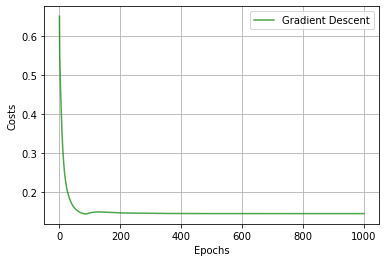

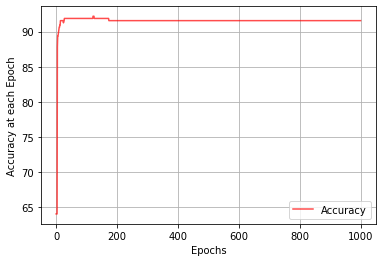

In [11]:
nn = DNN(layers=[6,2,1,2], acts=['t', 's', 'sm'],lr=0.05, iters=1000, optimizer='adam', lr_decay_period=10, lr_decay_rate=1.5, info=True)
nn.fit(xtr, ytr)

In [12]:
nn.accuracy[-1] ### Train Accuracy

91.5625

In [13]:
nn.compute_accuracy(xts.T, yts) ### Test Accuracy

92.5

In [10]:
for i in nn.info:
    print(i)

Optimized Weights
Optimized Biases
Epochs
Optimizer Used
Initial Learning Rate
Learning Rate after decay
Minimised Cost
Accuracy
